In [6]:
# Sam Brown
# sam_brown@mines.edu
# Date: 05/29/2025
# Goal: focus on gz stations near the grounding line and try to predict slip severity using time since last event, tide height, total delta, and pre-slip area

import sys
sys.path.append("/Users/sambrown04/Documents/SURF/whillans-surf/notebooks/SURF")

# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import my_lib.funcs

import util.coordinate_transforms

import Tides

import pyTMD

import time

# Set path to event files
evts_path = "/Users/sambrown04/Documents/SURF/Events/2013_2013Events2stas" 

In [7]:
# load events in
events_list = my_lib.funcs.load_evt(evts_path)
# events_list[0]['gz13x']

In [6]:
# want a dataframe of gz stations with columns: event_start, ?time_since_lastevent, tide height, pre-slip area, slip_severity

feat = my_lib.funcs.extract_event_features(events_list)

In [10]:
events_list[0].head()

,Unnamed: 0,time,la01x,la01y,la01z,la01res,la01res_avg,la02x,la02y,la02z,...,gz17res,gz17res_avg,gz18x,gz18y,gz18z,gz18res,gz18res_avg,sum_res_avg,ressum,event
0,1634606,2013-10-11 18:51:30,-282631.516389,-560616.318475,94.3331,0.442123,0.338985,-276793.579511,-560938.207272,94.5066,...,0.002968,0.067066,-167757.779291,-588319.556813,53.8549,0.002892,0.055873,3.144578,3.293584,1.0
1,1634607,2013-10-11 18:51:45,-282631.510762,-560616.320296,94.3243,0.442123,0.338985,-276793.579335,-560938.209383,94.4484,...,0.002968,0.067066,-167757.778440,-588319.559887,53.8248,0.002892,0.055873,3.144578,3.293598,1.0
2,1634608,2013-10-11 18:52:00,-282631.516826,-560616.320627,94.3270,0.442123,0.338985,-276793.583686,-560938.207235,94.4889,...,0.002968,0.067066,-167757.781207,-588319.559098,53.8419,0.002892,0.055873,3.144578,3.293665,1.0
3,1634609,2013-10-11 18:52:15,-282631.511169,-560616.319413,94.3441,0.442123,0.338985,-276793.579448,-560938.208652,94.5002,...,0.002968,0.067066,-167757.778150,-588319.557138,53.8481,0.002892,0.055873,3.144578,3.293665,1.0
4,1634610,2013-10-11 18:52:30,-282631.516933,-560616.318878,94.3316,0.442123,0.338985,-276793.587073,-560938.207588,94.4717,...,0.002952,0.067066,-167757.782888,-588319.555473,53.8265,0.002892,0.055873,3.144578,3.430693,1.0


In [7]:
feat[50].head()

,station,pre-slip_area,slip_severity,peak_time,total_delta,start_time
0,la02x,43.468647,8.116086e-07,4065.0,0.301455,2013-05-19 07:37:15
1,la08x,67.095304,3.437345e-07,4050.0,0.204397,2013-05-19 07:37:15
2,gz01x,123.360295,5.327449e-07,4050.0,0.306556,2013-05-19 07:37:15
3,gz02x,113.695603,4.300297e-07,4005.0,0.301011,2013-05-19 07:37:15
4,gz03x,177.987353,4.542322e-07,4050.0,0.319742,2013-05-19 07:37:15


We need to filter to just be gz and add the tide height and time since last slip for each event.

In [20]:
# Make a list of events with only gz stations
gz_df = pd.DataFrame(columns = ["station", "pre-slip_area", "slip_severity", "peak_time", "total_delta", "start_time"])

for i, event in enumerate(feat):

    for _,row in event.iterrows():

        # print(row['station'][0:2])
        if row['station'][0:2] == "gz":
            
            gz_df.loc[gz_df.shape[0]] = row.iloc[:6].values




            

In [21]:
# ensure proper dtypes
gz_df['pre-slip_area'] = pd.to_numeric(gz_df['pre-slip_area'], errors='coerce')
gz_df['slip_severity'] = pd.to_numeric(gz_df['slip_severity'], errors='coerce')
gz_df['total_delta']   = pd.to_numeric(gz_df['total_delta'], errors='coerce')
gz_df['peak_time']  = pd.to_numeric(gz_df['peak_time'], errors='coerce')

gz_df['start_time'] = pd.to_datetime(gz_df['start_time'], errors='coerce')


In [22]:
# get average x and y cor and lat lon for the gz stations
# need a list of x cors and a list of y cors
x_cors = []
y_cors = []

pre = 'gz'
numbers = ['01','02','03','04','05','12','13','14','15','16','17','18'] # If station is not operated this year it is not included
    
for num in numbers:
    station = f"{pre}{num}"

    x_col = f"{station}x"
    y_col = f"{station}y"
    
    # loop through events to get first instance station is transmitting
    for i, event in enumerate(events_list):
        if not event[x_col].isna().any():# make sure location is transmitting
            # get first instance of coordinates
            x_cors.append(event.at[0, x_col]) 
            y_cors.append(event.at[0,y_col])
            break

In [23]:
avg_x_cor = sum(x_cors) / len(x_cors)
avg_y_cor = sum(y_cors) / len(y_cors)

In [28]:
print(avg_x_cor, avg_y_cor)

-168955.1491394913 -599694.5432784811


In [17]:
# Setup model

### USER DEFINED PATH TO TIDE MODEL ###
tide_dir = "/Users/sambrown04/Documents/SURF"
#######################################

tide_mod = "CATS2008-v2023"

tides = Tides.Tide(tide_mod, tide_dir)

model1 = pyTMD.io.model(tide_dir, format="netcdf").elevation(tide_mod)
constituents = pyTMD.io.OTIS.read_constants(
    model1.grid_file,
    model1.model_file,
    model1.projection,
    type=model1.type,
    grid=model1.format,
)

In [119]:
# function that takes the x_cors and y_cors and time and returns the tide.


def get_tide_height(days, x_cor, y_cor, start_time):
    """ Get tide height for <days> days from initial date <start_time>, at the coordinates <x_cor> and <y_cor>.

    Parameters
    ----------
    days : int
        Number of days to calculate tide height for.
    x_cor : float
        PS71 x coordinate of tide calculation
    y_cor : _type_
        PS71 y coordinate of tide calculation
    start_time : _type_
        Starting date in %Y-%m-%d %H:%M:%S format

    Returns
    -------
    Pd DataFrame
        columns=['Time', 'Tide_h']
    """

    spacing = 1

    HR_PER_DAY = 24
    MIN_PER_HR = 60

    dates_timeseries = []
    initial_time = datetime.datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
    for i in range(days * HR_PER_DAY * MIN_PER_HR // spacing):  # 30 days * 24 hr/day * 60 min/hr * 1/10 calculations/min
        dates_timeseries.append(initial_time + datetime.timedelta(minutes=spacing * i))

    # Convert to lon and lat
    lon, lat = util.coordinate_transforms.xy2ll(x_cor, y_cor)
    # print(lon, lat)

    
    tides = Tides.Tide(tide_mod, tide_dir)
    
    # start_time = time.time()
    tide_results = tides.tidal_elevation(
        model1,
        constituents,
        [lon],
        [lat],
        dates_timeseries,
    ).data.T[0]
    # end_time = time.time()
    # elapsed_time = end_time - start_time
    # print(f"Elapsed time: {elapsed_time} seconds")

    out = pd.DataFrame(columns = ['Time', 'Tide_h'])
    out.loc[:,"Time"] = dates_timeseries 
    out.loc[:,"Tide_h"] = tide_results
    return out
    
    

In [41]:
# tide_h = get_tide_height(10, avg_x_cor, avg_y_cor, '2013-05-19 07:37:15')
# print(tide_h)
tide_h.dtypes

Time      datetime64[ns]
Tide_h            object
dtype: object

In [77]:
# Find the earliest and latest time to determine what number for day param we will use to get data

earliest_time = min(gz_df['start_time'])
latest_time = max(gz_df['start_time'])

print(earliest_time, latest_time)

2013-01-01 15:50:00 2013-12-31 21:43:45


In [121]:
# get full year of tide data: incremented by 1 minute
tide_dat = get_tide_height(365, avg_x_cor, avg_y_cor, str(earliest_time))

In [139]:
tide_dat.head()

,Time,Tide_h
0,2013-01-01 15:50:00,55.625562
1,2013-01-01 15:51:00,55.549655
2,2013-01-01 15:52:00,55.472309
3,2013-01-01 15:53:00,55.393526
4,2013-01-01 15:54:00,55.313305


In [109]:
# For each row in gz_df, find the closest time in the tide_dat, and assign the corresponding tide height
# we will be approximating to the minute, as that is all we can do
gz_df['tide_h'] = None
gz_df.head()

,station,pre-slip_area,slip_severity,peak_time,total_delta,start_time,tide_h
0,gz01x,70.239013,5.288333e-07,5880.0,0.342674,2013-10-11 18:51:30,None
1,gz02x,63.487532,3.912669e-07,5850.0,0.332198,2013-10-11 18:51:30,None
2,gz03x,70.879174,6.087319e-07,5865.0,0.347563,2013-10-11 18:51:30,None
3,gz05x,79.245871,4.482453e-07,5865.0,0.311682,2013-10-11 18:51:30,None
4,gz13x,104.216890,5.944295e-07,5835.0,0.362921,2013-10-11 18:51:30,None


In [141]:
# want to make model times down to minute to match
tide_dat['Time'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M"))

0         2013-01-01 15:50
1         2013-01-01 15:51
2         2013-01-01 15:52
3         2013-01-01 15:53
4         2013-01-01 15:54
                ...       
525595    2014-01-01 15:45
525596    2014-01-01 15:46
525597    2014-01-01 15:47
525598    2014-01-01 15:48
525599    2014-01-01 15:49
Name: Time, Length: 525600, dtype: object

In [171]:
for i, row in gz_df.iterrows():
    time_str = row['start_time'].strftime("%Y-%m-%d %H:%M")

    index = tide_dat[tide_dat['Time'] == time_str].index
    if not index.empty:
        tide_r = index[0]
        gz_df.at[i, 'tide_h'] = tide_dat.at[tide_r, 'Tide_h']

    

In [177]:
gz_df.head()

,station,pre-slip_area,slip_severity,peak_time,total_delta,start_time,tide_h
0,gz01x,70.239013,5.288333e-07,5880.0,0.342674,2013-10-11 18:51:30,57.59807
1,gz02x,63.487532,3.912669e-07,5850.0,0.332198,2013-10-11 18:51:30,57.59807
2,gz03x,70.879174,6.087319e-07,5865.0,0.347563,2013-10-11 18:51:30,57.59807
3,gz05x,79.245871,4.482453e-07,5865.0,0.311682,2013-10-11 18:51:30,57.59807
4,gz13x,104.216890,5.944295e-07,5835.0,0.362921,2013-10-11 18:51:30,57.59807


In [187]:
# Encode slip severity (threshold of 9 * 10^-7 explored in impulsive_ratio.ipynb)
gz_df['impulsive'] = None
gz_df['impulsive'] = (gz_df['slip_severity'] > 9* (10 ** -7)).astype(int)

In [189]:
gz_df.head(20)

,station,pre-slip_area,slip_severity,peak_time,total_delta,start_time,tide_h,impulsive
0,gz01x,70.239013,5.288333e-07,5880.0,0.342674,2013-10-11 18:51:30,57.59807,0
1,gz02x,63.487532,3.912669e-07,5850.0,0.332198,2013-10-11 18:51:30,57.59807,0
2,gz03x,70.879174,6.087319e-07,5865.0,0.347563,2013-10-11 18:51:30,57.59807,0
3,gz05x,79.245871,4.482453e-07,5865.0,0.311682,2013-10-11 18:51:30,57.59807,0
4,gz13x,104.216890,5.944295e-07,5835.0,0.362921,2013-10-11 18:51:30,57.59807,0
5,gz14x,109.553053,6.441359e-07,5805.0,0.357526,2013-10-11 18:51:30,57.59807,0
6,gz15x,79.085800,4.388854e-07,5820.0,0.346706,2013-10-11 18:51:30,57.59807,0
7,gz16x,79.765588,5.783037e-07,5835.0,0.324539,2013-10-11 18:51:30,57.59807,0
8,gz17x,68.066140,5.569547e-07,5865.0,0.345583,2013-10-11 18:51:30,57.59807,0
9,gz18x,103.234064,5.985740e-07,5850.0,0.340565,2013-10-11 18:51:30,57.59807,0


In [194]:
# Random Forest
X = gz_df[['pre-slip_area', 'total_delta', 'tide_h']]
y = gz_df['impulsive']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [220]:
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=150,
                       random_state=42)

In [222]:
y_pred = rf_model.predict(X_test)

# 7. Evaluate the results
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[804 123]
 [118 545]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       927
           1       0.82      0.82      0.82       663

    accuracy                           0.85      1590
   macro avg       0.84      0.84      0.84      1590
weighted avg       0.85      0.85      0.85      1590

Accuracy Score: 0.8484276729559749


In [224]:
import shap

feature_names = ['pre-slip_area', 'total_delta', 'tide_h']

importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

         Feature  Gini Importance
1    total_delta         0.429193
2         tide_h         0.290711
0  pre-slip_area         0.280097


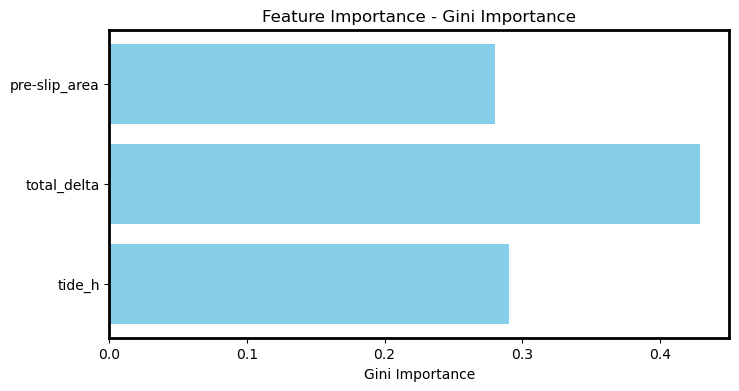

In [225]:
plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # invert y-axis for better visualization
plt.show()

Text(0, 0.5, 'Slip_severity')

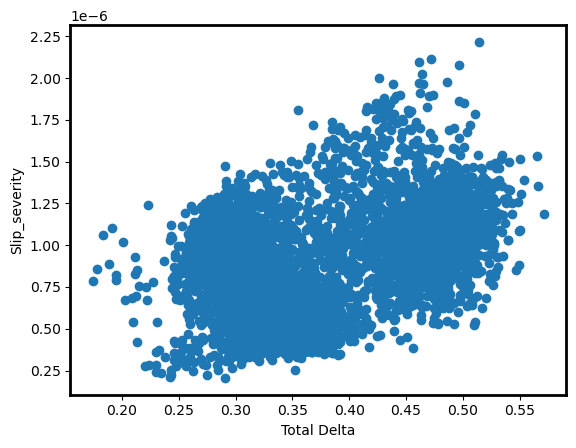

In [231]:
# correlation between total delta and slip severity?
plt.scatter(gz_df['total_delta'], gz_df['slip_severity'])
plt.xlabel("Total Delta")
plt.ylabel("Slip_severity")

Definitely some type of correlation. Also looks like there is some clustering. Maybe same pattern seen in station specific graphs?